In [1]:
from google.colab import drive
try:
  drive.mount('/content/drive', force_remount=False)
except:
  pass

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/AI_for_Health

/content/drive/MyDrive/AI_for_Health


In [3]:
data_path = "mimic-iii-clinical-database-1.4"

# Import packages

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

# Load data

In [5]:
# Load MIMIC datasets
diagnoses = pd.read_csv(os.path.join(data_path,'DIAGNOSES_ICD.csv.gz'), compression="gzip",
                        usecols=["SUBJECT_ID", "HADM_ID", "ICD9_CODE"])
patients = pd.read_csv(os.path.join(data_path,'PATIENTS.csv.gz'), compression="gzip",
                       usecols=["SUBJECT_ID", "GENDER", "DOB"])
admissions = pd.read_csv(os.path.join(data_path,'ADMISSIONS.csv.gz'), compression="gzip",
                         usecols=["SUBJECT_ID", "HADM_ID", "ADMITTIME", "DISCHTIME",
                                  "DEATHTIME", "ADMISSION_TYPE", "RELIGION", "MARITAL_STATUS", "ETHNICITY"])
labevents = pd.read_csv(os.path.join(data_path,'LABEVENTS.csv.gz'), compression="gzip",
                        usecols=["SUBJECT_ID", "CHARTTIME", "HADM_ID", "ITEMID","VALUE","VALUENUM","VALUEUOM"])

# Load aggregated chartevents data (aggregated in SQL)
chartevents = pd.read_csv("stroke_chartevents_agg.csv")

# Data processing

### 1. Diagnosis_ICD data

In [6]:
# Flag for diagnosis: Stroke
df = diagnoses.copy()
df['STROKE'] = df['ICD9_CODE'].str.startswith(('433', '434')) | (df['ICD9_CODE'] == 436)
df['STROKE'] = df['STROKE'].astype(int)
df = df.groupby(['SUBJECT_ID','HADM_ID'])['STROKE'].max().reset_index()

In [7]:
df['STROKE'].value_counts()

,count
STROKE,
0,56441
1,2535


### 2. Admissions and Patients data

In [8]:
# Merge admissions, patients, and fil_diagnoses data
df = pd.merge(df, admissions, on=["SUBJECT_ID","HADM_ID"])
df = pd.merge(df, patients, on="SUBJECT_ID")

In [9]:
df['STROKE'].value_counts()

,count
STROKE,
0,56441
1,2535


In [10]:
# Calculate age function
def calculate_age(dob, admit):
  try:
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    admit_date = datetime.strptime(admit, "%Y-%m-%d %H:%M:%S")
    age = (admit_date - dob_date).days // 365
    return age
  except ValueError as e:
    print(f"Error processing dates: {e}")
    return None

# Apply calculate_age function to create "age" column
df["DOB"] = df["DOB"].astype(str)
df["ADMITTIME"] = df["ADMITTIME"].astype(str)
df["age"] = df.apply(lambda row: calculate_age(row["DOB"], row["ADMITTIME"]), axis=1)

# Filter for admissions that have age within range 0-100 years
df = df[df["age"] <= 100]

In [11]:
df['STROKE'].value_counts()

,count
STROKE,
0,53993
1,2367


In [12]:
# Compress the number of ethnicity categories
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER',
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ETHNICITY'].value_counts()

<ipython-input-12-3a5f49e66dcd>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
<ipython-input-12-3a5f49e66dcd>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

,count
ETHNICITY,
WHITE,39135
OTHER/UNKNOWN,7515
BLACK/AFRICAN AMERICAN,5646
HISPANIC/LATINO,2112
ASIAN,1952


In [13]:
# Reduce religion to terms of religious or not
df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(df['RELIGION'].value_counts())

RELIGION
RELIGIOUS        36984
NOT SPECIFIED    11373
UNOBTAINABLE      8003
Name: count, dtype: int64


<ipython-input-13-d755780e6957>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['RELIGION'].loc[~df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'


### 3. Labevents data

In [14]:
# Aggregate values in labevents data
df_lab = labevents.copy()

# Remove NA values
df_lab.dropna(inplace=True)

# Convert charttime to datetime format
df_lab["CHARTTIME"] = df_lab["CHARTTIME"].astype(str)
df_lab["CHARTTIME"] = pd.to_datetime(df_lab["CHARTTIME"])

# List of relevant lab test ITEMIDs
relevant_labs = {50931: "Glucose", 51301: "WBC",
                 51265: "Platelet", 50971: "Potassium",
                 50983: "Sodium"}

# Filter for relevant lab tests
df_lab = df_lab[df_lab["ITEMID"].isin(relevant_labs.keys())]

# Replace itemid with human-readable names
df_lab["lab_name"] = df_lab["ITEMID"].map(relevant_labs)

# Group by patient admission and lab test
agg_funcs = {"VALUENUM": ["mean", "std"]}
lab_summary = df_lab.groupby(["SUBJECT_ID", "HADM_ID", "lab_name"]).agg(agg_funcs)

# Reset column names
lab_summary.columns = ["_".join(col).strip() for col in lab_summary.columns]

# Pivot the table: Create separate columns for each lab_name's mean and std
lab_pivot = lab_summary.pivot_table(index=["SUBJECT_ID", "HADM_ID"],
                                    columns="lab_name",
                                    values=["VALUENUM_mean", "VALUENUM_std"])

# Flatten multi-index column names
lab_pivot.columns = [f"{metric}_{lab}" for metric, lab in lab_pivot.columns]
lab_pivot.columns = [x.removeprefix('VALUENUM_') for x in lab_pivot.columns]

# Reset index to ensure subject_id and hadm_id remain as columns
lab_pivot = lab_pivot.reset_index()

In [15]:
lab_pivot.head(5)

,SUBJECT_ID,HADM_ID,mean_Glucose,mean_Platelet,mean_Potassium,mean_Sodium,mean_WBC,std_Glucose,std_Platelet,std_Potassium,std_Sodium,std_WBC
0,2,163353.0,NaN,153.500000,NaN,NaN,11.050000,NaN,210.010714,NaN,NaN,15.485639
1,3,145834.0,125.6875,210.866667,4.105263,137.555556,12.533333,68.323465,59.568528,0.481287,3.713603,4.834499
2,4,185777.0,226.7500,286.428571,3.537500,137.750000,9.442857,71.757031,68.827943,0.324863,2.121320,1.610235
3,5,178980.0,NaN,309.000000,NaN,NaN,13.900000,NaN,NaN,NaN,NaN,NaN
4,6,107064.0,119.0000,247.947368,4.911765,134.411765,13.589474,31.862988,56.565079,0.365517,2.762671,6.907073


In [16]:
lab_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57176 entries, 0 to 57175
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SUBJECT_ID      57176 non-null  int64  
 1   HADM_ID         57176 non-null  float64
 2   mean_Glucose    50394 non-null  float64
 3   mean_Platelet   56973 non-null  float64
 4   mean_Potassium  52875 non-null  float64
 5   mean_Sodium     52858 non-null  float64
 6   mean_WBC        56989 non-null  float64
 7   std_Glucose     48858 non-null  float64
 8   std_Platelet    50526 non-null  float64
 9   std_Potassium   50712 non-null  float64
 10  std_Sodium      50609 non-null  float64
 11  std_WBC         50409 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 5.2 MB


### 4. Chartevents data

In [17]:
df_chart = chartevents.copy()

df_chart.rename(columns={'subject_id': 'SUBJECT_ID', 'hadm_id': 'HADM_ID', 'itemid': 'ITEMID'}, inplace=True)
df_chart.dropna(inplace=True)

# List of relevant lab test ITEMIDs
relevant_vitals = {220179: "Blood_Pressure", 220277: "Oxygen_Saturation"}

# Filter for relevant lab tests
df_chart = df_chart[df_chart["ITEMID"].isin(relevant_vitals.keys())]

# Replace itemid with human-readable names
df_chart["vital_name"] = df_chart["ITEMID"].map(relevant_vitals)

# Pivot the table: Create separate columns for each lab_name's mean and std
chart_pivot = df_chart.pivot_table(index=["SUBJECT_ID", "HADM_ID"],
                                    columns="vital_name",
                                    values=['mean_value', 'std_value'])

# Flatten multi-index column names
chart_pivot.columns = [f"{metric}_{lab}" for metric, lab in chart_pivot.columns]
chart_pivot.columns = [x.removeprefix('_value') for x in chart_pivot.columns]

# Reset index to ensure subject_id and hadm_id remain as columns
chart_pivot = chart_pivot.reset_index()

In [18]:
chart_pivot.head(5)

,SUBJECT_ID,HADM_ID,mean_value_Blood_Pressure,mean_value_Heart_Rate_211,mean_value_Heart_Rate_220045,mean_value_Oxygen_Saturation,mean_value_Respiratory_Rate,mean_value_Temperature_F,std_value_Blood_Pressure,std_value_Heart_Rate_211,std_value_Heart_Rate_220045,std_value_Oxygen_Saturation,std_value_Respiratory_Rate,std_value_Temperature_F
0,2,163353,NaN,140.750000,NaN,NaN,NaN,NaN,NaN,7.274384,NaN,NaN,NaN,NaN
1,3,145834,NaN,92.376471,NaN,NaN,NaN,NaN,NaN,19.908356,NaN,NaN,NaN,NaN
2,4,185777,NaN,90.354839,NaN,NaN,NaN,NaN,NaN,7.884789,NaN,NaN,NaN,NaN
3,6,107064,NaN,86.549451,NaN,NaN,NaN,NaN,NaN,6.898089,NaN,NaN,NaN,NaN
4,7,118037,NaN,132.000000,NaN,NaN,NaN,NaN,NaN,24.433583,NaN,NaN,NaN,NaN


In [19]:
chart_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54879 entries, 0 to 54878
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SUBJECT_ID                    54879 non-null  int64  
 1   HADM_ID                       54879 non-null  int64  
 2   mean_value_Blood_Pressure     21567 non-null  float64
 3   mean_value_Heart_Rate_211     33068 non-null  float64
 4   mean_value_Heart_Rate_220045  21915 non-null  float64
 5   mean_value_Oxygen_Saturation  21885 non-null  float64
 6   mean_value_Respiratory_Rate   21900 non-null  float64
 7   mean_value_Temperature_F      21271 non-null  float64
 8   std_value_Blood_Pressure      21567 non-null  float64
 9   std_value_Heart_Rate_211      33068 non-null  float64
 10  std_value_Heart_Rate_220045   21915 non-null  float64
 11  std_value_Oxygen_Saturation   21885 non-null  float64
 12  std_value_Respiratory_Rate    21900 non-null  float64
 13  s

### 5. Merge all the datasets together

In [ ]:
# Merge admissions, patients, and fil_diagnoses data
df = pd.merge(df, lab_pivot, on=["SUBJECT_ID","HADM_ID"])
df = pd.merge(df, chart_pivot, on=["SUBJECT_ID","HADM_ID"])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51437 entries, 0 to 51436
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SUBJECT_ID                    51437 non-null  int64  
 1   HADM_ID                       51437 non-null  int64  
 2   STROKE                        51437 non-null  int64  
 3   ADMITTIME                     51437 non-null  object 
 4   DISCHTIME                     51437 non-null  object 
 5   DEATHTIME                     5172 non-null   object 
 6   ADMISSION_TYPE                51437 non-null  object 
 7   RELIGION                      51437 non-null  object 
 8   MARITAL_STATUS                44399 non-null  object 
 9   ETHNICITY                     51437 non-null  object 
 10  HOSPITAL_EXPIRE_FLAG          51437 non-null  int64  
 11  GENDER                        51437 non-null  object 
 12  DOB                           51437 non-null  object 
 13  a

In [22]:
# Remove any rows that have NA values
df_rem_NA = df[['SUBJECT_ID', 'HADM_ID', 'STROKE',
                'RELIGION', 'ETHNICITY', 'GENDER', 'age',
                'mean_Glucose', 'mean_Platelet',
                'mean_Potassium', 'mean_Sodium', 'mean_WBC',
                'std_Glucose', 'std_Platelet',
                'std_Potassium', 'std_Sodium', 'std_WBC',
                'mean_value_Blood_Pressure', 'mean_value_Oxygen_Saturation',
                'std_value_Blood_Pressure','std_value_Oxygen_Saturation']]
df_rem_NA.dropna(inplace=True)

<ipython-input-22-fd3426e08045>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rem_NA.dropna(inplace=True)


In [23]:
df_rem_NA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19753 entries, 18 to 51436
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SUBJECT_ID                    19753 non-null  int64  
 1   HADM_ID                       19753 non-null  int64  
 2   STROKE                        19753 non-null  int64  
 3   RELIGION                      19753 non-null  object 
 4   ETHNICITY                     19753 non-null  object 
 5   GENDER                        19753 non-null  object 
 6   age                           19753 non-null  int64  
 7   mean_Glucose                  19753 non-null  float64
 8   mean_Platelet                 19753 non-null  float64
 9   mean_Potassium                19753 non-null  float64
 10  mean_Sodium                   19753 non-null  float64
 11  mean_WBC                      19753 non-null  float64
 12  std_Glucose                   19753 non-null  float64
 13  std_P

In [24]:
df_rem_NA['STROKE'].value_counts()

,count
STROKE,
0,18732
1,1021


In [25]:
df_rem_NA.to_csv("stroke_model_data.csv", index=False)

# Model Data Preparation

### 1. Create dummy variables for categorical features

In [ ]:
# Load preprocessed data
#df_rem_NA = pd.read_csv("stroke_model_data.csv")

In [26]:
df_rem_NA.columns

Index(['SUBJECT_ID', 'HADM_ID', 'STROKE', 'RELIGION', 'ETHNICITY', 'GENDER',
       'age', 'mean_Glucose', 'mean_Platelet', 'mean_Potassium', 'mean_Sodium',
       'mean_WBC', 'std_Glucose', 'std_Platelet', 'std_Potassium',
       'std_Sodium', 'std_WBC', 'mean_value_Blood_Pressure',
       'mean_value_Oxygen_Saturation', 'std_value_Blood_Pressure',
       'std_value_Oxygen_Saturation'],
      dtype='object')

In [27]:
df_dummyvar = pd.get_dummies(df_rem_NA, columns=['RELIGION', 'ETHNICITY', 'GENDER'])

In [28]:
df_dummyvar.columns

Index(['SUBJECT_ID', 'HADM_ID', 'STROKE', 'age', 'mean_Glucose',
       'mean_Platelet', 'mean_Potassium', 'mean_Sodium', 'mean_WBC',
       'std_Glucose', 'std_Platelet', 'std_Potassium', 'std_Sodium', 'std_WBC',
       'mean_value_Blood_Pressure', 'mean_value_Oxygen_Saturation',
       'std_value_Blood_Pressure', 'std_value_Oxygen_Saturation',
       'RELIGION_NOT SPECIFIED', 'RELIGION_RELIGIOUS', 'RELIGION_UNOBTAINABLE',
       'ETHNICITY_ASIAN', 'ETHNICITY_BLACK/AFRICAN AMERICAN',
       'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_OTHER/UNKNOWN',
       'ETHNICITY_WHITE', 'GENDER_F', 'GENDER_M'],
      dtype='object')

### 2. Check and correct imbalances in the data

In [29]:
df_dummyvar['STROKE'].value_counts()

,count
STROKE,
0,18732
1,1021


In [30]:
# Undersample Majority Class
df_majority = df_dummyvar[df_dummyvar["STROKE"] == 0].sample(n=900, random_state=42)  # Keep 900 non-stroke cases
df_minority = df_dummyvar[df_dummyvar["STROKE"] == 1]  # Keep all 1,000 stroke cases

# Merge both subsets
df_balanced = pd.concat([df_majority, df_minority])

### 3. Split the data into Train and Test

In [32]:
# Split data
X = df_balanced.drop(columns=['SUBJECT_ID', 'HADM_ID', 'STROKE'])
y = df_balanced['STROKE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (1536, 25)
Test shape: (385, 25)


# Random Forest Model

In [33]:
# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
print("Random Forest Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest Model Performance:
Accuracy: 0.6649350649350649
AUC: 0.6586043360433604
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       180
           1       0.66      0.76      0.71       205

    accuracy                           0.66       385
   macro avg       0.67      0.66      0.66       385
weighted avg       0.67      0.66      0.66       385



In [45]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

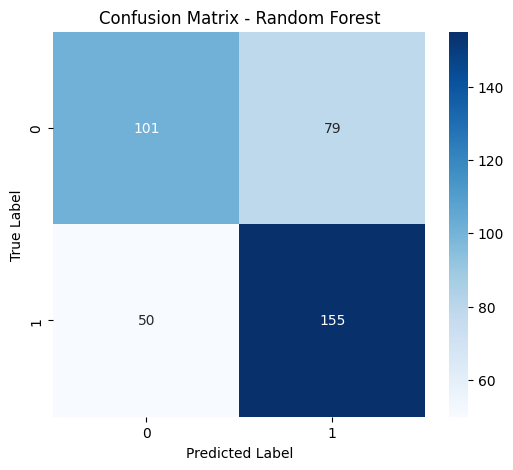

In [46]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, "Random Forest")

# Hyperparameter Tuning

In [57]:
# Define hyperparameter grid (smaller for grid search)
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [5, 10, None],
              'min_samples_leaf': [1, 2, 4]}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Grid Search
grid_search = GridSearchCV(rf_model, param_grid=param_grid)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

# Evaluate
print("Tuned Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("AUC:", roc_auc_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 100}
Tuned Random Forest Performance:
Accuracy: 0.6831168831168831
AUC: 0.6756775067750678
              precision    recall  f1-score   support

           0       0.70      0.56      0.62       180
           1       0.67      0.79      0.73       205

    accuracy                           0.68       385
   macro avg       0.69      0.68      0.67       385
weighted avg       0.69      0.68      0.68       385



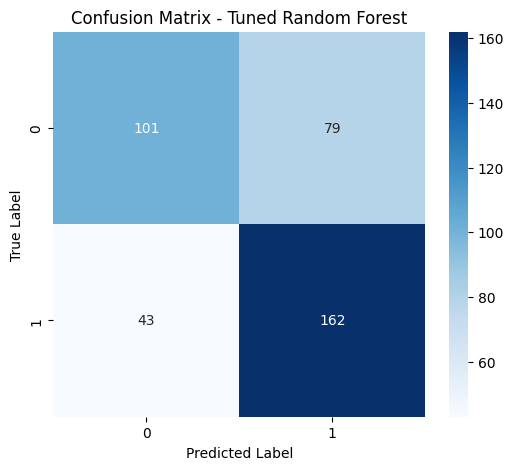

In [58]:
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_best, "Tuned Random Forest")

# Evaluation

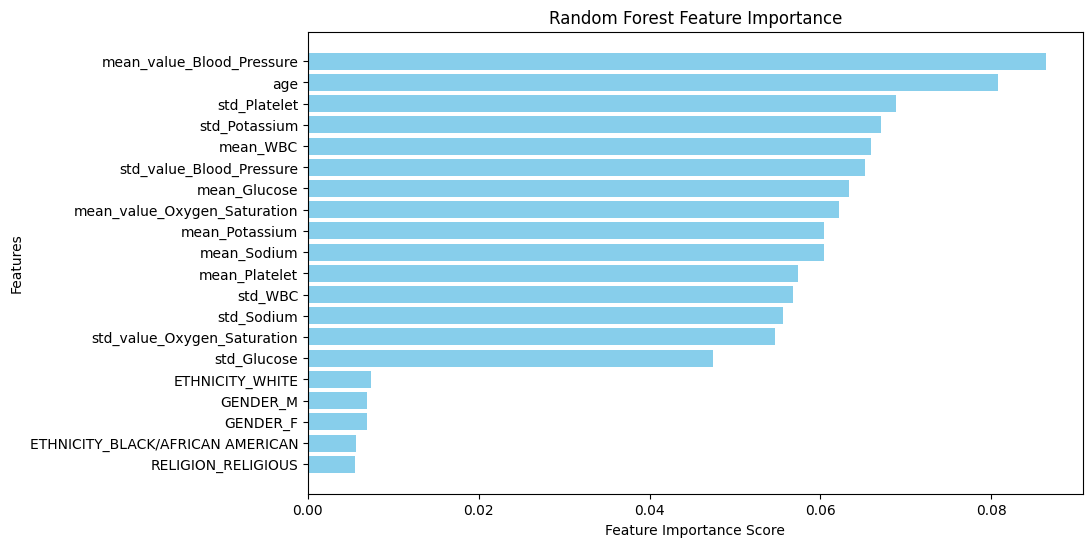

In [60]:
# Get feature importance scores from tuned Random Forest
rf_importance = best_rf.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(rf_importance)[::-1]
sorted_features = np.array(X_train.columns)[sorted_idx]

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:20], rf_importance[sorted_idx][:20], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


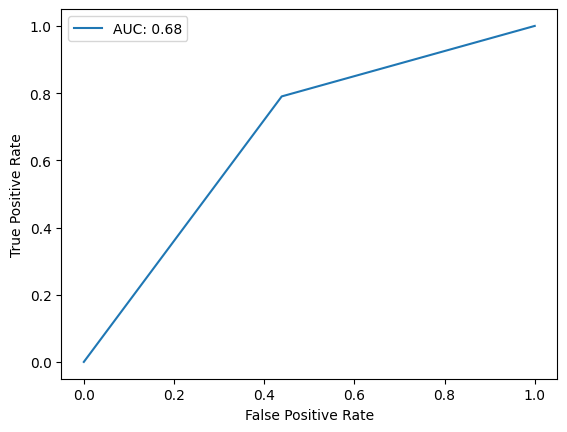

In [62]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_best)
plt.plot(fpr, tpr, label="AUC: {:.2f}".format(auc(fpr, tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
